In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/models/grey_to_color_model.h5
/kaggle/input/landscape-image-colorization/landscape Images/gray/6234.jpg
/kaggle/input/landscape-image-colorization/landscape Images/gray/1269.jpg
/kaggle/input/landscape-image-colorization/landscape Images/gray/3863.jpg
/kaggle/input/landscape-image-colorization/landscape Images/gray/6241.jpg
/kaggle/input/landscape-image-colorization/landscape Images/gray/623.jpg
/kaggle/input/landscape-image-colorization/landscape Images/gray/2193.jpg
/kaggle/input/landscape-image-colorization/landscape Images/gray/3750.jpg
/kaggle/input/landscape-image-colorization/landscape Images/gray/2008.jpg
/kaggle/input/landscape-image-colorization/landscape Images/gray/5982.jpg
/kaggle/input/landscape-image-colorization/landscape Images/gray/2081.jpg
/kaggle/input/landscape-image-colorization/landscape Images/gray/6588.jpg
/kaggle/input/landscape-image-colorization/landscape Images/gray/3919.jpg
/kaggle/input/landscape-image-colorization/landscape Images/gray/6197

In [3]:
from tqdm import tqdm
import re
import cv2
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import layers
print(tf.config.list_physical_devices('GPU'))
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)
tf.random.set_seed(42)
np.random.seed(42)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 128
color_img = []
path = '../input/landscape-image-colorization/landscape Images/color'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
    if i == '6000.jpg':
        break
    else:    
        img = cv2.imread(path + '/'+i,1)
        # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        color_img.append(img_to_array(img))


gray_img = []
path = '../input/landscape-image-colorization/landscape Images/gray'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
     if i == '6000.jpg':
        break
     else: 
        img = cv2.imread(path + '/'+i,1)

        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        gray_img.append(img_to_array(img))

 84%|████████▍ | 6000/7129 [00:49<00:09, 120.67it/s]


In [5]:
train_gray_image = gray_img[:5500]
train_color_image = color_img[:5500]

test_gray_image = gray_img[5500:]
test_color_image = color_img[5500:]
# reshaping
train_g = np.reshape(train_gray_image,(len(train_gray_image),SIZE,SIZE,3))
train_c = np.reshape(train_color_image, (len(train_color_image),SIZE,SIZE,3))
print('Train color image shape:',train_c.shape)


test_gray_image = np.reshape(test_gray_image,(len(test_gray_image),SIZE,SIZE,3))
test_color_image = np.reshape(test_color_image, (len(test_color_image),SIZE,SIZE,3))
print('Test color image shape',test_color_image.shape)

Train color image shape: (5500, 128, 128, 3)
Test color image shape (500, 128, 128, 3)


In [6]:
def create_model():
    inputs = layers.Input(shape=[128, 128, 3])
    # encoder
    l1 = layers.Conv2D(filters=128, kernel_size=(3,3), padding = 'same', strides = 2, activation='relu')(inputs)
    l2 = layers.Conv2D(filters=128, kernel_size=(3,3), padding = 'same', strides = 2, activation='relu')(l1)
    l3 = layers.Conv2D(filters=256, kernel_size=(3,3), padding = 'same', strides = 2, activation='relu')(l2)
    l3 = layers.BatchNormalization()(l3)
    l4 = layers.Conv2D(filters=512, kernel_size=(3,3), padding = 'same', strides = 2, activation='relu')(l3)
    l4 = layers.BatchNormalization()(l4)
    
    # mid layer
    l5 = layers.Conv2D(filters=512, kernel_size=(3,3), padding = 'same', strides = 2, activation='relu')(l4)
    l5 = layers.BatchNormalization()(l5)
    
    # decoder
    l6 = layers.Conv2DTranspose(filters=512, kernel_size=(3,3), padding = 'same', strides = 2, activation='relu')(l5)
    l6 = layers.concatenate([l6, l4])
    l7 = layers.Conv2DTranspose(filters=256, kernel_size=(3,3), padding = 'same', strides = 2, activation='relu')(l6)
    l7 = layers.concatenate([l7, l3])
    l8 = layers.Conv2DTranspose(filters=128, kernel_size=(3,3), padding = 'same', strides = 2, activation='relu')(l7)
    l8 = layers.concatenate([l8, l2])
    l9 = layers.Conv2DTranspose(filters=128, kernel_size=(3,3), padding = 'same', strides = 2, activation='relu')(l8)
    l9 = layers.concatenate([l9, l1])
    l10 = layers.Conv2DTranspose(filters=3, kernel_size=(3,3), padding = 'same', strides = 2, activation='relu')(l9)
    l10 = layers.concatenate([l10, inputs])
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(l10)
    
    return tf.keras.Model(inputs=inputs, outputs=output)

    

In [7]:
def preprocess_image(filename):
    img = tf.io.read_file(filename)
    img = tf.image.decode_png(img, channels=1)
    img = tf.image.resize(img, (128, 128))
    img = tf.image.random_flip_left_right(img)
    img = (tf.cast(img, tf.float32) / 127.5) - 1.0
    return img

def load_dataset():
    gray_filenames = ["/kaggle/input/landscape-image-colorization/landscape Images/gray/" + str(i) + ".jpg" for i in range(7129)]
    colored_filenames = ["/kaggle/input/landscape-image-colorization/landscape Images/color/" + str(i) + ".jpg" for i in range(7129)]
    dataset = tf.data.Dataset.from_tensor_slices((gray_filenames, colored_filenames))
    dataset = dataset.map(lambda gray_file, colored_file: (preprocess_image(gray_file), preprocess_image(colored_file)))
    batch_size = 32
    train_dataset = dataset.take(5700).shuffle(buffer_size=1000).batch(batch_size)
    val_dataset = dataset.skip(5700).batch(batch_size)
    return train_dataset, val_dataset

train_dataset, val_dataset = load_dataset()

In [8]:
model = create_model()
model.compile(optimizer='adam', loss = 'mae',metrics = ['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 128)  3584        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 128)  147584      ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 16, 16, 256)  295168      ['conv2d_1[0][0]']           

In [9]:
# training the model
num_epochs = 50
#model.fit(train_g, train_c, epochs=num_epochs)
#model.save("grey_to_color_model.h5")
model = tf.keras.models.load_model('/kaggle/input/models/grey_to_color_model.h5')

1/1 [==============================] - 0s 23ms/step


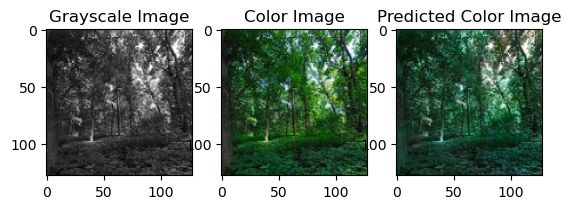

In [52]:
#img = cv2.imread('/kaggle/input/models1/output-onlinejpgtools.jpg', 1)
#resizing image
#img = cv2.resize(img, (128, 128))
#img = img.astype('float32') / 255.0
#img = img_to_array(img)


#gray_img = cv2.imread('/kaggle/input/landscape-image-colorization/landscape Images/gray/2.jpg')
#gray_img = gray_img.resize((128, 128))
#gray_img = np.array(gray_img, dtype=np.float32) / 255
#gray_img = np.expand_dims(gray_img, axis=-1)
#gray_img = np.expand_dims(gray_img, axis=0)
#gray_img = img_to_array(gray_img)

# Load color image and preprocess
color_img = cv2.imread('/kaggle/input/landscape-image-colorization/landscape Images/color/5501.jpg')
color_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB)
color_img = cv2.resize(color_img, (128, 128))
color_img = color_img.astype('float32') / 255.0
color_img = img_to_array(color_img)

# Make prediction
pred_color_img = np.clip(model.predict(test_gray_image[1].reshape(1, 128, 128, 3)),0.0,1.0).reshape(128, 128, 3)

# Change the order of color channels from BGR to RGB
pred_color_img = pred_color_img[..., ::-1]

# Rescale and convert to uint8
#pred_color_img = pred_color_img[0] * 255
#pred_color_img = pred_color_img.astype(np.uint8)

# Display results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(test_gray_image[1], cmap='gray')
ax1.set_title('Grayscale Image')
ax2.imshow(color_img)
ax2.set_title('Color Image')
ax3.imshow(pred_color_img)
ax3.set_title('Predicted Color Image')
plt.show()